#LLama 3.1-8B initialization

In [3]:
!pip install unsloth "xformers==0.0.28.post2" > /dev/null 2>&1
!pip uninstall unsloth -y  > /dev/null 2>&1 && pip install --upgrade --no-cache-dir "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git" > /dev/null 2>&1

In [2]:
from unsloth import FastLanguageModel

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Meta-Llama-3.1-8B-Instruct",
    max_seq_length = 8192,
    load_in_4bit = True,
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
==((====))==  Unsloth 2024.11.1: Fast Llama patching. Transformers = 4.46.2.
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.5.0+cu124. CUDA = 7.5. CUDA Toolkit = 12.4.
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.28.post2. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/340 [00:00<?, ?B/s]

In [4]:
from transformers import TextStreamer
from unsloth.chat_templates import get_chat_template
tokenizer = get_chat_template(
    tokenizer,
    chat_template = "llama-3.1",
    mapping = {"role" : "from", "content" : "value", "user" : "human", "assistant" : "gpt"},
)
FastLanguageModel.for_inference(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096, padding_idx=128004)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaExtendedRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): L

#Fetching dataset

In [5]:
import os

if os.path.exists("dataset/hotpot_train_v1.1.json"):
    print("Dataset already exists")
else:
    if not os.path.exists("dataset"):
        os.mkdir("dataset")

    import requests
    response = requests.get('http://curtis.ml.cmu.edu/datasets/hotpot/hotpot_train_v1.1.json')

    with open('dataset/hotpot_dataset.json', 'wb') as f:
        f.write(response.content)
    print("Dataset downloaded")

Dataset downloaded


#Load dataset

In [6]:
import json
with open('dataset/hotpot_dataset.json', 'r') as f:
    dataset = json.load(f)

for i in range(len(dataset)):
    dataset[i]['context_d'] = {}
    for entry in dataset[i]['context']:
        dataset[i]['context_d'][entry[0]] = []
        for sentence in entry[1]:
            dataset[i]['context_d'][entry[0]].append(sentence)

In [7]:
import collections

print(f'Dataset size: {len(dataset)}')
print(f'Question types: {collections.Counter([x["type"] for x in dataset])}')
print(f'Question level: {collections.Counter([x["level"] for x in dataset])}')

print('\nSample data:')
for i in range(5):
    print(f'id: {dataset[i]["_id"]}')
    print(f'type: {dataset[i]["type"]}')
    print(f'level: {dataset[i]["level"]}')
    print(f'question: {dataset[i]["question"]}')
    print(f'context: {dataset[i]["context_d"]}')
    print(f'supporting_facts: {dataset[i]["supporting_facts"]}')
    print(f'answer: {dataset[i]["answer"]}')
    print()

Dataset size: 90447
Question types: Counter({'bridge': 72991, 'comparison': 17456})
Question level: Counter({'medium': 56814, 'easy': 17972, 'hard': 15661})

Sample data:
id: 5a7a06935542990198eaf050
type: comparison
level: medium
question: Which magazine was started first Arthur's Magazine or First for Women?
context: {'Radio City (Indian radio station)': ["Radio City is India's first private FM radio station and was started on 3 July 2001.", ' It broadcasts on 91.1 (earlier 91.0 in most cities) megahertz from Mumbai (where it was started in 2004), Bengaluru (started first in 2001), Lucknow and New Delhi (since 2003).', ' It plays Hindi, English and regional songs.', ' It was launched in Hyderabad in March 2006, in Chennai on 7 July 2006 and in Visakhapatnam October 2007.', ' Radio City recently forayed into New Media in May 2008 with the launch of a music portal - PlanetRadiocity.com that offers music related news, videos, songs, and other music-related features.', ' The Radio statio

In [8]:
num_titles_per_fact = [len(set([fact[0] for fact in item["supporting_facts"]])) for item in dataset]
num_entries_per_title = [len(item["supporting_facts"]) for item in dataset]

max_titles = max(num_titles_per_fact) if num_titles_per_fact else 0
min_titles = min(num_titles_per_fact) if num_titles_per_fact else 0
avg_titles = sum(num_titles_per_fact) / len(num_titles_per_fact) if num_titles_per_fact else 0

max_entries = max(num_entries_per_title) if num_entries_per_title else 0
min_entries = min(num_entries_per_title) if num_entries_per_title else 0
avg_entries = sum(num_entries_per_title) / len(num_entries_per_title) if num_entries_per_title else 0

total_entries = sum(num_entries_per_title)

print({
    "max_titles": max_titles,
    "min_titles": min_titles,
    "avg_titles": avg_titles,
    "max_entries": max_entries,
    "min_entries": min_entries,
    "avg_entries": avg_entries,
    "total_entries": total_entries
})

print(collections.Counter(num_entries_per_title))

{'max_titles': 2, 'min_titles': 2, 'avg_titles': 2.0, 'max_entries': 12, 'min_entries': 2, 'avg_entries': 2.3846451513040785, 'total_entries': 215684}
Counter({2: 63676, 3: 20017, 4: 5814, 5: 724, 6: 141, 7: 52, 8: 17, 9: 4, 12: 1, 11: 1})


#LLM usage template

In [9]:
messages = [
    {"from": "human", "value": "How to do RAG?"},
]
inputs = tokenizer.apply_chat_template(messages, tokenize = True, add_generation_prompt = True, return_tensors = "pt").to("cuda")

text_streamer = TextStreamer(tokenizer)
_ = model.generate(input_ids = inputs, streamer = text_streamer, max_new_tokens = 1024, use_cache = True)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 July 2024

<|eot_id|><|start_header_id|>human<|end_header_id|>

How to do RAG?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

RAG stands for Read, Analyze, and Generate. It's a process used in various fields, including research, problem-solving, and learning. Here's a general outline of the RAG process:

1. **Read**: Gather and read relevant information, data, or materials related to the topic or problem. This step helps you understand the context, identify key points, and clarify any doubts.

2. **Analyze**: Once you have a good understanding of the information, analyze it to identify patterns, relationships, and potential solutions. This step involves breaking down complex information into smaller parts, evaluating the relevance of each part, and drawing connections between them.

3. **Generate**: Based on your analysis, generate new ideas, solutions, or insights

#Naive RAG

In [10]:
!pip install numpy > /dev/null 2>&1
!pip install matplotlib > /dev/null 2>&1
!pip install sentence-transformers > /dev/null 2>&1

In [11]:
def is_included_list(list1, list2):
  list1 = [tuple(vec) for vec in list1]
  list2 = [tuple(vec) for vec in list2]
  for vec1 in list1:
    if vec1 not in list2:
      return False
  return True

def is_included_string(str1, str2):
    str1_lower = str1.lower()
    str2_lower = str2.lower()

    return str1_lower in str2_lower or str2_lower in str1_lower

def evaluate_model_answers(dataset, model_answer_list, is_approach_1):
  results = []
  for i in range(len(dataset)):
    correct_answer = dataset[i]['answer']
    supporting_facts = dataset[i]['supporting_facts']

    model_answer = model_answer_list[i][0]
    model_supporting_facts = model_answer_list[i][1]


    is_model_answer_correct = is_included_string(correct_answer, model_answer)

    if not is_approach_1:
      is_supporting_facts_correct = is_included_list(supporting_facts, model_supporting_facts)

    else:
      supporting_facts_approach1_set = set([tmp[0] for tmp in supporting_facts])
      model_supporting_facts_set = set(model_supporting_facts)

      is_supporting_facts_correct = supporting_facts_approach1_set.issubset(model_supporting_facts_set)

    results.append([is_model_answer_correct, is_supporting_facts_correct])

  return results

In [12]:
import numpy as np
from sentence_transformers import SentenceTransformer, util


# method=1: Single-entry approach
# method=2: Title-entry combination approach
# method=3: Two-stage matching approach
def naive_rag(question, context, embedding_model, method, top_k):
    # Context: dictionary, with the title being the key, and a list of entries under that title being the value

    question_embedding = embedding_model.encode(question)

    titles = []
    entries = []
    indices = []

    if method == 1:
        for title, entry_list in context.items():
            titles.append(title)
            entries.append(title + ': ' + ' '.join(entry_list))

        entries_embedding = embedding_model.encode(entries)
        cos_sim_score = util.cos_sim(question_embedding, entries_embedding).flatten()

        top_k_indices = (-cos_sim_score).argsort()[:top_k]
        best_titles = [titles[i] for i in top_k_indices]

        return ['Answer placeholder', best_titles]

    if method == 2:
        for title, entry_list in context.items():
            for idx, entry in enumerate(entry_list):
                indices.append(idx)
                titles.append(title)
                entries.append(title + ': ' + entry)

        entries_embedding = embedding_model.encode(entries)
        cos_sim_score = util.cos_sim(question_embedding, entries_embedding).flatten()

        top_k_indices = (-cos_sim_score).argsort()[:top_k]
        best_comb = [[titles[i], indices[i]] for i in top_k_indices]

        return ['Answer placeholder', best_comb]

    if method == 3:
        for title, entry_list in context.items():
            for idx, entry in enumerate(entry_list):
                indices.append(idx)
                titles.append(title)
                entries.append(entry)

        titles_embedding = embedding_model.encode(titles)
        titles_cos_sim_score = util.cos_sim(question_embedding, titles_embedding).flatten()
        entries_embedding = embedding_model.encode(entries)
        entries_cos_sim_score = util.cos_sim(question_embedding, entries_embedding).flatten()

        title_weight = 0.5
        total_cos_sim_score = title_weight * np.array(titles_cos_sim_score) + (1 - title_weight) * np.array(entries_cos_sim_score)

        top_k_indices = (-total_cos_sim_score).argsort()[:top_k]
        best_comb = [[titles[i], indices[i]] for i in top_k_indices]

        return ['Answer placeholder', best_comb]

In [15]:
# Single-entry approach
import time

eval_list = []

embedding_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
model_answer_list = []
start = time.time()

test_size = 500
for i in range(test_size):
    if (i+1) % 100 == 0:
        print(f'Question {i+1}/500, time spent: {time.time() - start}s')
    model_answer_list.append(naive_rag(dataset[i]['question'], dataset[i]['context_d'], embedding_model, 1, 2))

eval_result = evaluate_model_answers(dataset[:test_size], model_answer_list, True)
eval_list.append(sum([1 for tmp in eval_result if tmp[1]]) / len(eval_result) * 100)
print(f'Supporting fact accuracy for single-entry approach: {eval_list[0]}%')

# model_answer_list = []
# start = time.time()

# for i in range(test_size):
#     if (i+1) % 100 == 0:
#         print(f'Question {i+1}/500, time spent: {time.time() - start}s')
#     model_answer_list.append(naive_rag(dataset[i]['question'], dataset[i]['context_d'], embedding_model, 1, 4))

# eval_result = evaluate_model_answers(dataset[:test_size], model_answer_list, True)
# eval_list.append(sum([1 for tmp in eval_result if tmp[1]]) / len(eval_result))
# print(sum([1 for tmp in eval_result if tmp[1]]) / len(eval_result))

Question 100/500, time spent: 3.6397197246551514s
Question 200/500, time spent: 8.377023935317993s
Question 300/500, time spent: 14.416449308395386s
Question 400/500, time spent: 20.687721014022827s
Question 500/500, time spent: 28.370601177215576s
Supporting fact accuracy for single-entry approach: 27.6%


In [16]:
# Title-entry combination approach
embedding_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
model_answer_list = []
start = time.time()

test_size = 500
for i in range(test_size):
    if (i+1) % 100 == 0:
        print(f'Question {i+1}/500, time spent: {time.time() - start}s')
    model_answer_list.append(naive_rag(dataset[i]['question'], dataset[i]['context_d'], embedding_model, 2, 4))

eval_result = evaluate_model_answers(dataset[:test_size], model_answer_list, False)
eval_list.append(sum([1 for tmp in eval_result if tmp[1]]) / len(eval_result) * 100)
print(f'Supporting fact accuracy for title-entry combination approach: {eval_list[1]}%')

Question 100/500, time spent: 10.016165494918823s
Question 200/500, time spent: 20.08785343170166s
Question 300/500, time spent: 29.599648475646973s
Question 400/500, time spent: 39.31279182434082s
Question 500/500, time spent: 48.498271226882935s
Supporting fact accuracy for title-entry combination approach: 19.6%


In [17]:
# Two-stage matching approach
embedding_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
model_answer_list = []
start = time.time()

test_size = 500
for i in range(test_size):
    if (i+1) % 100 == 0:
        print(f'Question {i+1}/500, time spent: {time.time() - start}s')
    model_answer_list.append(naive_rag(dataset[i]['question'], dataset[i]['context_d'], embedding_model, 3, 4))

eval_result = evaluate_model_answers(dataset[:test_size], model_answer_list, False)
eval_list.append(sum([1 for tmp in eval_result if tmp[1]]) / len(eval_result) * 100)
print(f'Supporting fact accuracy for two-stage matching approach: {eval_list[2]}%')

Question 100/500, time spent: 7.659440755844116s
Question 200/500, time spent: 16.802820920944214s
Question 300/500, time spent: 24.200067043304443s
Question 400/500, time spent: 31.531306266784668s
Question 500/500, time spent: 38.69359827041626s
Supporting fact accuracy for two-stage matching approach: 26.0%


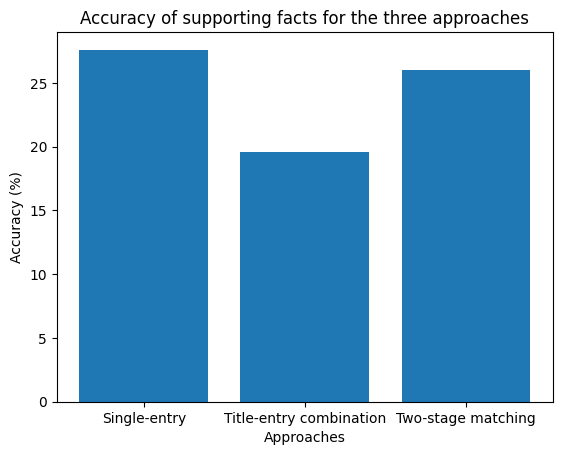

In [20]:
import matplotlib.pyplot as plt

plt.bar(['Single-entry', 'Title-entry combination', 'Two-stage matching'], eval_list)

plt.title("Accuracy of supporting facts for the three approaches")
plt.xlabel("Approaches")
plt.ylabel("Accuracy (%)")

plt.show()

#Intermediate RAG

In [ ]:
prompt = """
Instruction:
"You are given a question, and your task is to identify the specific pieces of information needed to answer it. Format your response clearly by providing a numbered list of the key details or topics that must be searched. For each item, describe exactly what needs to be found."

Example Input:
Question: "What is the capital of France, and who was the president of France in 2020?"

Example Response:
"To answer the question, I need to search for the following information:

The capital of France.
The name of the president of France in 2020."
"""

#Our RAG